In [1]:
%reload_ext autoreload
%autoreload 2

# Imports

In [2]:
from kret_notebook import *  # NOTE import first
from kret_matplotlib.mpl_nb_imports import *
from kret_np_pd.np_pd_nb_imports import *
from kret_polars.polars_nb_imports import *
from kret_rosetta.rosetta_nb_imports import *
from kret_lgbm.lgbm_nb_imports import *
from kret_sklearn.sklearn_nb_imports import *
from kret_torch_utils.torch_nb_imports import *
from kret_lightning.lightning_nb_imports import *
from kret_tqdm.tqdm_nb_imports import *
from kret_type_hints.types_nb_imports import *
from kret_utils.utils_nb_imports import *

# from kret_wandb.wandb_nb_imports import *  # NOTE this is slow to import

[kret_np_pd.np_pd_nb_imports] Imported kret_np_pd.np_pd_nb_imports in 0.0222 seconds
Loaded environment variables from /Users/Akseldkw/coding/kretsinger/.env
[kret_matplotlib.mpl_nb_imports] Imported kret_matplotlib.mpl_nb_imports in 0.1760 seconds
[kret_polars.polars_nb_imports] Imported kret_polars.polars_nb_imports in 0.0771 seconds
[kret_rosetta.rosetta_nb_imports] Imported kret_rosetta.rosetta_nb_imports in 0.0000 seconds
[kret_lgbm.lgbm_nb_imports] Imported kret_lgbm.lgbm_nb_imports in 0.0000 seconds
[kret_sklearn.sklearn_nb_imports] Imported kret_sklearn.sklearn_nb_imports in 0.1378 seconds
[kret_torch_utils.torch_nb_imports] Imported kret_torch_utils.torch_nb_imports in 0.3671 seconds
[kret_lightning.lightning_nb_imports] Imported kret_lightning.lightning_nb_imports in 0.0013 seconds
[kret_tqdm.tqdm_nb_imports] Imported kret_tqdm.tqdm_nb_imports in 0.0000 seconds
[kret_type_hints.types_nb_imports] Imported kret_type_hints.types_nb_imports in 0.0006 seconds
[kret_utils.utils_nb_

# Load Data

In [3]:
df = pd.read_csv(UKS_CONSTANTS.DATA_DIR / "medical_cost.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [5]:
dtt(df)

,Id,age,sex,bmi,children,smoker,region,charges
,int64,int64,object,float64,int64,object,object,float64
45,46,55,male,37.300,0,no,southwest,20630.284
103,104,61,female,29.920,3,yes,southeast,30942.192
194,195,18,male,34.430,0,no,southeast,1137.470
421,422,61,male,35.860,0,yes,southeast,46599.108
1210,1211,36,male,30.875,1,no,northwest,5373.364


## Cleanup

In [6]:
UKS_NP_PD.data_cleanup(df)

In [7]:
dtt(df)

,Id,age,sex,bmi,children,smoker,region,charges
,category,int64,category,float64,int64,bool,category,float64
138,139,54,female,31.900,3,False,southeast,27322.734
534,535,64,male,40.480,0,False,southeast,13831.115
931,932,39,female,32.500,1,False,southwest,6238.298
1295,1296,20,male,22.000,1,False,southwest,1964.780
1328,1329,23,female,24.225,2,False,northeast,22395.744


In [8]:
df.drop(["Id"], inplace=True, axis=1)

In [9]:
features = df.drop("charges", axis=1)
target = df["charges"]

x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.15, random_state=0)

## Scaler

In [10]:
dtt(features)

,age,sex,bmi,children,smoker,region
,int64,category,float64,int64,bool,category
336,60,male,25.740,0,False,southeast
379,62,male,31.460,1,False,southeast
660,37,male,46.530,3,False,southeast
700,21,female,34.870,0,False,southeast
819,33,female,35.530,0,True,northwest


In [11]:
float_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]

In [12]:
power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)


column_transform = ColumnTransformer(
    transformers=[
        ("scaler", power_transformer, float_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
    verbose=True,
)

In [13]:
pipeline_x = PipelinePD(steps=[("column_transform", column_transform)])

In [14]:
x_train = pipeline_x.fit_transform_df(x_train)
x_val = pipeline_x.transform_df(x_val)

[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


## Build LGBM Dataset

In [15]:
x_train_ds = DatasetLGBM(
    x_train,
)

In [16]:
x_train_ds.set_categorical_feature(cat_cols)

In [17]:
# ds_params = {
#     "feature_name": list(X_train.columns),
#     "categorical_feature": cat_cols,
# }
# train_data = lgbm.Dataset(X_train, label=Y_train, **ds_params)
# test_data = lgbm.Dataset(X_val, label=Y_val, reference=train_data, **ds_params)
# train_data.get_feature_name()
# Implementation

## Train Model

In [18]:
raise ValueError("Stop")

ValueError: Stop

In [20]:
LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'num_leaves': 31,
 'max_depth': 7,
 'learning_rate': 0.1,
 'n_jobs': -2}

In [21]:
model = LGBMRegressor(**LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS)

In [22]:
fit_defaults = LGBM_Defaults.LGBM_FIT_DEFAULTS
fit_defaults

{'eval_metric': 'l2',
 'callbacks': [<lightgbm.callback._EarlyStoppingCallback at 0x1072b36b0>,
  <lightgbm.callback._LogEvaluationCallback at 0x107325730>]}

In [ ]:
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], categorical_feature=cat_cols, **LGBM_Defaults.LGBM_FIT_DEFAULTS)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 1137, number of used features: 6
[LightGBM] [Info] Start training from score 13136.954371
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [24]:
# model = lgb.train(
#     params=LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS,  # type:ignore[arg-type]
#     train_set=train_data,
#     valid_sets=[test_data],
#     num_boost_round=1000,
#     callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)],
# )

# NOTE ^ bad performance

In [25]:
y_pred = model.predict(x_val)

In [76]:
gs = GroupScatterUKS(y_val, y_pred)

In [77]:
fig, ax = UKS_MPL.subplots(1, 1)

In [78]:
color = (np.float64(0.12156862745098039), np.float64(0.4666666666666667), np.float64(0.7058823529411765))

In [79]:
ax.scatter(y_val, y_pred, color=color, **gs.raw_scatter_kwargs)

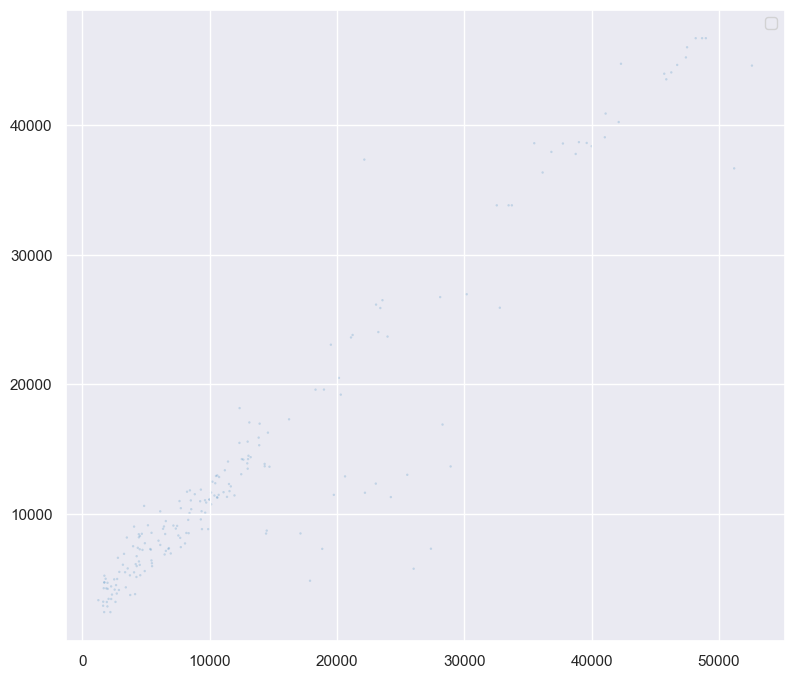

In [80]:
fig

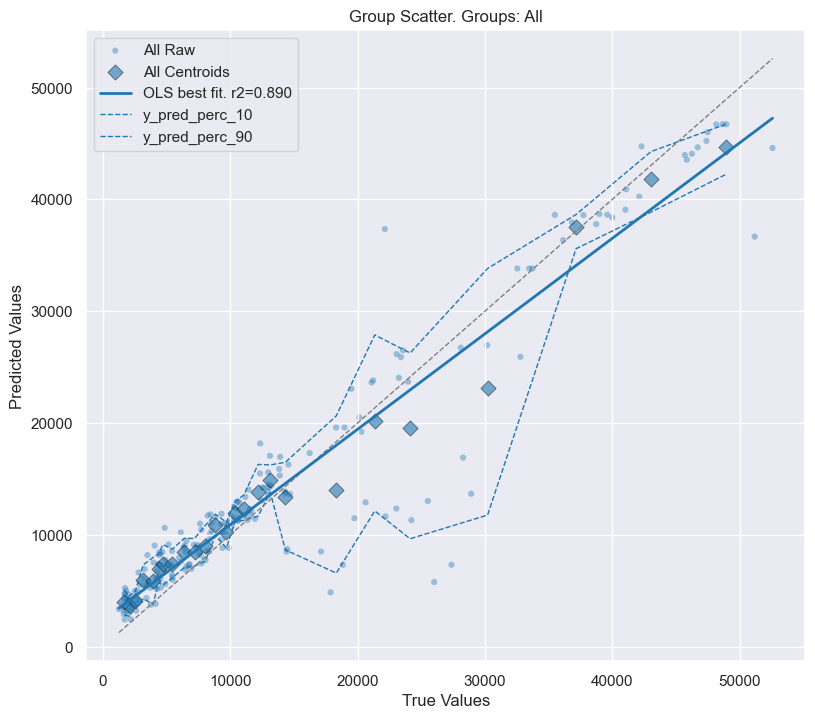

In [81]:
gs.plot(scatters=("raw", "centroids"), percentiles=(10, 90))

# Sandbox

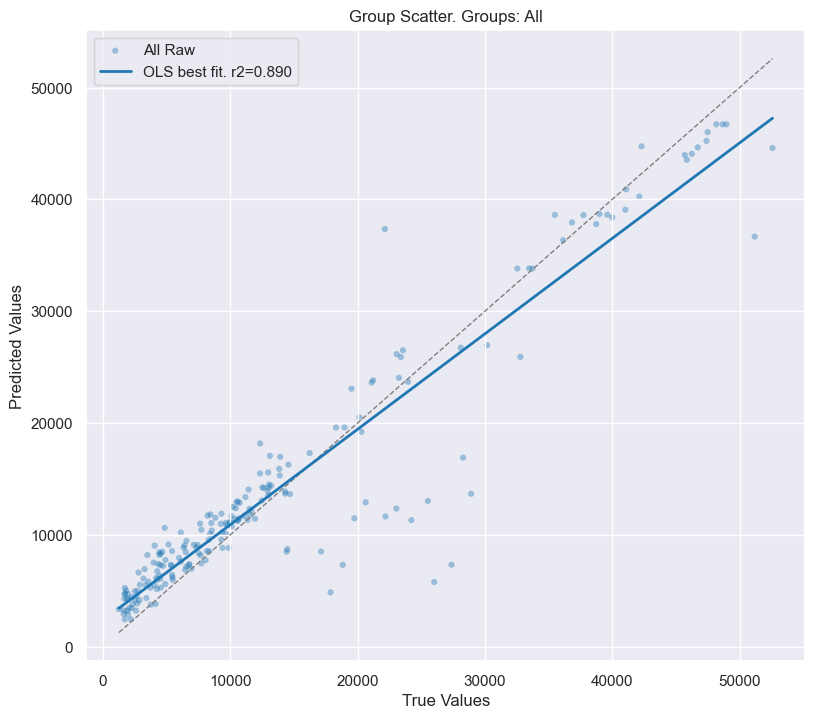

In [82]:
gs.plot(
    scatters=("raw",),
)

In [83]:
centroids = gs.DfFull.drop_duplicates(subset=["category", "centroid_bin"])
categories = centroids.category.cat.categories

In [84]:
dtt([gs.DfFull, gs.DfBaseSorted])

y_true 
 y_pred 
 category 
 filt 
 centroid_bin 
 y_true_centroid 
 y_pred_centroid 
 y_pred_perc_10 
 y_pred_perc_90 
 
 
 
 float64 
 float64 
 category 
 bool 
 category 
 float64 
 float64 
 float64 
 float64 
 
 
 
 
 16 
 2254.797 
 4413.940 
 All 
 True 
 1 
 2028.848 
 3693.295 
 2736.936 
 4496.748 
 
 
 97 
 9361.327 
 10214.010 
 All 
 True 
 12 
 9698.377 
 10269.828 
 8832.082 
 11115.202 
 
 
 121 
 11554.224 
 11766.228 
 All 
 True 
 15 
 12185.066 
 13811.323 
 11666.269 
 16292.425 
 
 
 132 
 13012.209 
 14236.099 
 All 
 True 
 16 
 13142.580 
 14883.349 
 13785.247 
 16245.146 
 
 
 183 
 38998.546 
 38695.766 
 All 
 True 
 22 
 37163.814 
 37554.075 
 35593.317 
 38651.756 
 
 
 
 
 
 
 y_true 
 y_pred 
 category 
 filt 
 
 
 
 float64 
 float64 
 category 
 bool 
 
 
 
 
 16 
 2254.797 
 4413.940 
 All 
 True 
 
 
 97 
 9361.327 
 10214.010 
 All 
 True 
 
 
 121 
 11554.224 
 11766.228 
 All 
 True 
 
 
 132 
 13012.209 
 14236.099 
 All 
 True 
 
 
 183 
 38998.546 
 38695.766 
 All 
 True

In [85]:
from kret_np_pd.sort_utils import SortUtils

In [86]:
SortUtils.is_sorted(gs.DfFull.y_true)

True